In [66]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive/')

import os
from datetime import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [67]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv")
#df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/coin_Bitcoin.csv")

In [68]:
df.head()


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df['Timestamp'] = df['Timestamp'].apply(lambda x: datetime.fromtimestamp(x))
df = df.fillna(method='ffill', axis=0)

In [ ]:
df.isnull().sum()

In [71]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 05:33:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,2014-12-01 05:34:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,2014-12-01 05:35:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,2014-12-01 05:36:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,2014-12-01 05:37:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [72]:
df = df[7::60]

In [73]:
data_time = df['Timestamp']

In [74]:
def plot_all_features(data):
    plot_cols = ['Open', 'High', 'Low', 'Close']
    plot_features = data[plot_cols]
    plot_features.index = data_time
    _ = plot_features.plot(subplots=True)

    plot_features = data[plot_cols][-500:]
    plot_features.index = data_time[-500:]
    _ = plot_features.plot(subplots=True)

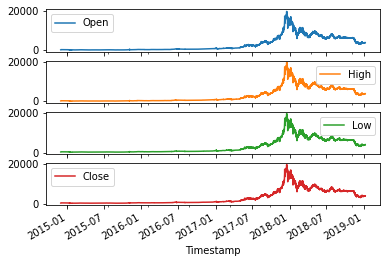

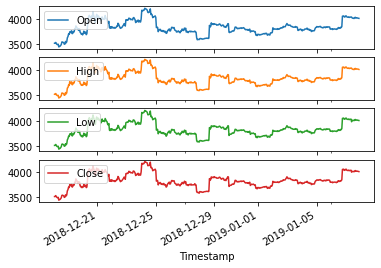

In [75]:
plot_all_features(df)

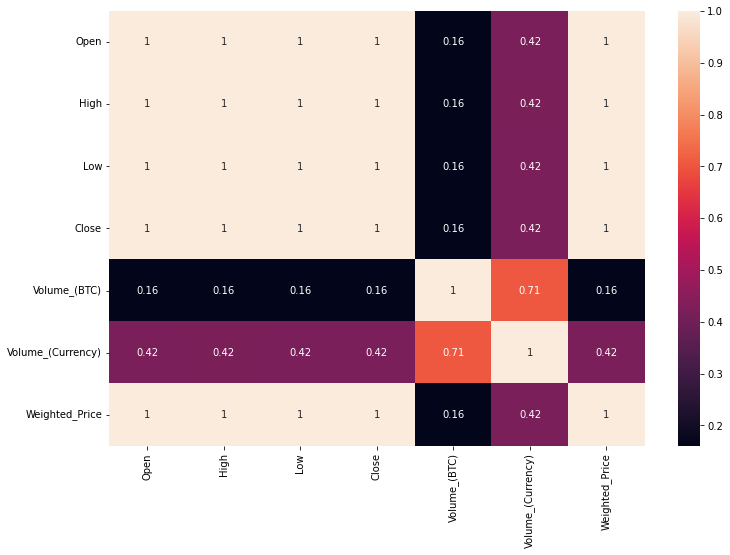

In [76]:
corr = df.corr()
#mask = np.triu(np.ones_like(corr, dtype=bool))
#f, ax = plt.subplots(figsize=(15, 12))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True)
plt.show()

In [77]:
df = df[['Timestamp', 'Close']]
df = df.set_index('Timestamp')
#data_test = data_test[['Date', 'Close']]
#data_test = data_test.set_index('Date')

In [78]:
def plot_unique_feature(data):
    plt.figure(figsize=(12, 8))
    plt.plot(data['Close'])
    plt.ylabel('Close')
    plt.xlabel('Year')
    plt.title('Close Price')


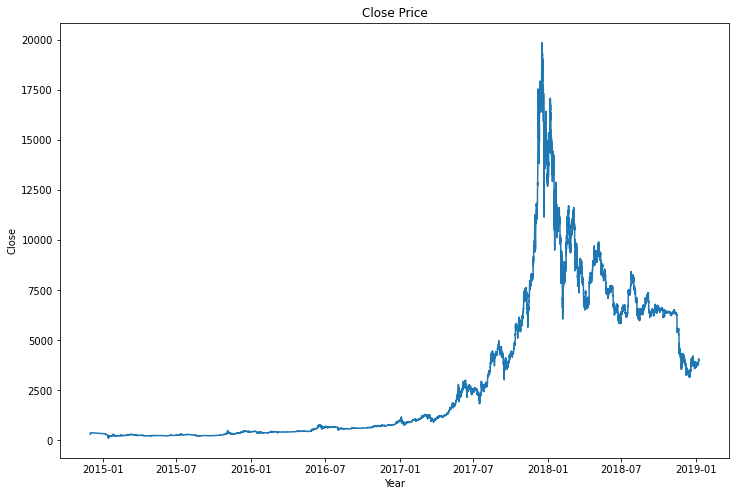

In [79]:
plot_unique_feature(df)
#plot_unique_feature(data_test)

In [80]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,34996.0,3106.746376,3757.139341,114.76,406.625,904.105,6217.9,19870.02


In [81]:
def split_data(data, split_size=0.8):
    n = len(data)
    train_df = data[:int(n * split_size)]
    test_df = data[int(n * split_size):]
    return train_df, test_df


In [82]:
train_df, test_df = split_data(df)

In [83]:
def normalize_data(train_data, test_data):
    train_mean = train_data.mean()
    train_std = train_data.std()

    train_data = (train_data - train_mean) / train_std
    test_data = (test_data - train_mean) / train_std
    return train_data, test_data


In [84]:
train_df, test_df = normalize_data(train_df, test_df)

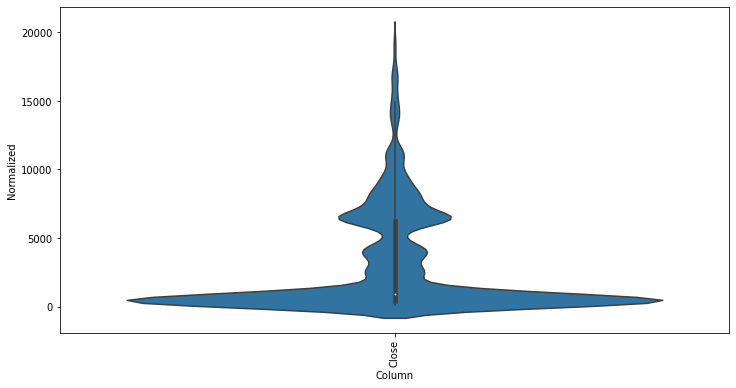

In [85]:
train_mean = train_df.mean()
train_std = train_df.std()
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [86]:
def plot_data(train_data, test_data):
    plt.figure(figsize=(10, 7))
    plt.scatter(x=train_data.index, y=train_data['Close'], s=5, label='Train Data')
    plt.scatter(x=test_data.index, y=test_data['Close'], s=5, label='Test Data')
    plt.legend()
    plt.show()


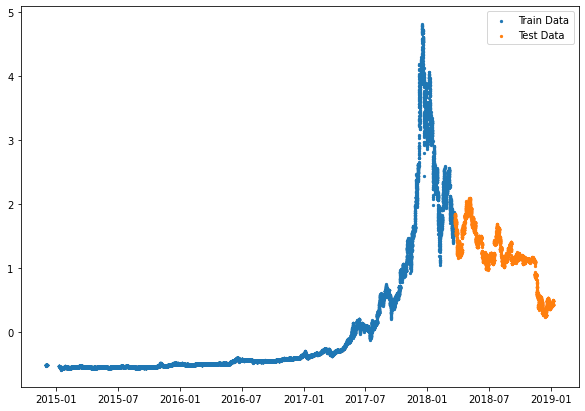

In [87]:
plot_data(train_df, test_df)

In [88]:
INPUT_WIDTH = 24
LABEL_WIDTH = 1

In [89]:
def split_window(data):
    input_slice = slice(0, INPUT_WIDTH)
    output_slice = slice(INPUT_WIDTH, None)

    inputs = data[:, input_slice, :]
    outputs = data[:, output_slice, :]

    return inputs, outputs

In [90]:
def make_dataset(data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data= data,
        targets = None,
        sequence_length = INPUT_WIDTH + LABEL_WIDTH,
        sequence_stride = 1,
        shuffle = True,
        batch_size = 32
    )


    ds = ds.map(split_window)
    return ds

In [91]:
train_df = make_dataset(train_df)
test_df = make_dataset(test_df)

In [92]:
def compile_and_fit(model, train_ds, test_ds, patience=1):
    model.compile(
        loss= tf.losses.MeanAbsoluteError(),
        optimizer= tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()]
    )


    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience= patience,
        mode = 'min'
    )

    history = model.fit(
        train_ds,
        epochs=5,
        validation_data= test_ds,
        callbacks= [early_stopping]
    )

    return history

In [93]:
simple_model = tf.keras.models.Sequential([
                                    tf.keras.layers.LSTM(32, return_sequences=False),
                                    tf.keras.layers.Dense(1)
                                    ])

In [95]:
history = compile_and_fit(simple_model, train_df, test_df)

Epoch 1/5
875/875 [==============================] - 17s 16ms/step - loss: 0.0086 - mean_absolute_error: 0.0086 - val_loss: 0.0113 - val_mean_absolute_error: 0.0113
Epoch 2/5
875/875 [==============================] - 14s 16ms/step - loss: 0.0076 - mean_absolute_error: 0.0076 - val_loss: 0.0106 - val_mean_absolute_error: 0.0106
Epoch 3/5
875/875 [==============================] - 14s 17ms/step - loss: 0.0073 - mean_absolute_error: 0.0073 - val_loss: 0.0178 - val_mean_absolute_error: 0.0178


In [96]:
def plot_performance(history):
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.ylabel("MAE")
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

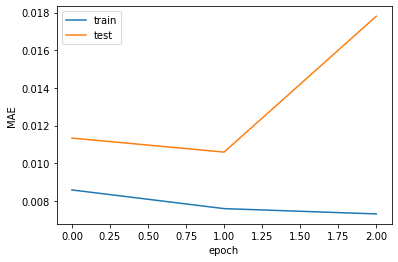

In [97]:
plot_performance(history)

In [98]:
def plot_graph(model):
    plt.figure(figsize=(10, 7))
    train_df.shuffle(buffer_size=len(train_df))
    for b, (x, label) in enumerate(train_df.take(4)):
        plt.subplot(2, 2, b+ 1)
        predictions = model.predict(x)[b]
        plt.plot(list(range(INPUT_WIDTH)), x[b, :, -1])
        plt.plot(INPUT_WIDTH, label[b].numpy(), 'g^', label="label")
        plt.plot(INPUT_WIDTH, predictions, 'r+', label='prediction')
        plt.legend()

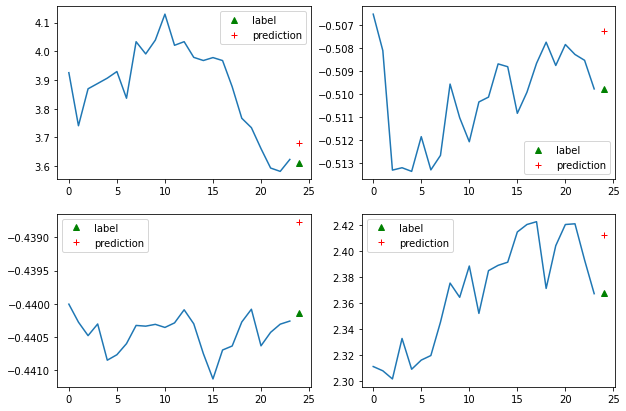

In [99]:
plot_graph(simple_model)